<a href="https://colab.research.google.com/github/QuatZo/kickstarter-predictor/blob/master/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries & dataset

In [36]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time
import statistics as stats
import requests
import pickle
import json

from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.base import clone
from sklearn.externals.joblib import dump, load

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler

df = pd.read_csv('http://puma.swstats.info/files/kickstarter_with_trends.csv', index_col="ID")
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'tokenized_name', 'trend'],
      dtype='object')

# Prepare for data cleaning

In [0]:
link = 'https://3l7z4wecia.execute-api.us-east-1.amazonaws.com/default/api-dynamodb/'

get_categories = {
  "operation": "list",
  "table": "categories",
}

categories = requests.post(link, json=get_categories)

categories = categories.json()['Items']
categories_proper = dict()
for item in categories:
  categories_proper[item['name']] = item['id'] # map NAME to ID

get_main_categories = {
  "operation": "list",
  "table": "maincategories",
}

main_categories = requests.post(link, json=get_main_categories)

main_categories = main_categories.json()['Items']
main_categories_proper = dict()
for item in main_categories:
  main_categories_proper[item['name']] = item['id'] # map NAME to ID

get_countries = {
  "operation": "list",
  "table": "countries",
}

countries = requests.post(link, json=get_countries)

countries = countries.json()['Items']
countries_proper = dict()
for item in countries:
  countries_proper[item['name']] = item['id'] # map NAME to ID

# Clean & prepare data
* Calculate campaign length 
* Delete all incomplete data (like country == N,0")
* Delete all kickstarter projects with different state than 'failed' and 'successful' 
* Cast to numerical types all non-numerical features and drop all empty data
* Use Label Encoding or One-Hot Encoding

In [39]:
df_clean = df.copy()

indexes = df_clean[df_clean['country'] == 'N,0"'].index
df_clean.drop(indexes, inplace=True)
# drop live & undefined states
indexes = df_clean[(df_clean['state'] == 'live') | (df_clean['state'] == 'undefined')].index
df_clean.drop(indexes, inplace=True)

df_clean['campaign_length'] = pd.to_timedelta((pd.to_datetime(df_clean['deadline']) - pd.to_datetime(df_clean['launched'])), unit='days').dt.days
# df_clean = df_clean[(df_clean['usd_goal_real'] >= 10) & (df_clean['campaign_length'] >= 7)] # drop all with lower goal than 10$ and shorter than week

##########################################################
# """ Label Encoding - if you want to run this, just comment lines with quotation marks
jsons = dict()
map_dict = {
    'category': categories_proper,
    'main_category': main_categories_proper,
    'country': countries_proper,
}
for key, val in map_dict.items():
  df_clean[key] = df_clean[key].map(val)

json.dump(jsons, open('categories.json', 'w'))

df_clean.drop(['tokenized_name', 'currency', 'name'], inplace=True, axis=1)
df_clean.dropna(inplace=True)
# """
##########################################################

###########################################################
""" One-Hot Encoding - if you want to run this, just comment lines with quotation marks
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['category', 'main_category', 'currency', 'country'])], sparse_threshold=0, n_jobs=-1)
onehot = pd.DataFrame(column_transformer.fit_transform(df_clean)).set_index(df_clean.index)
new_cols_encoding = [col.replace('encoder__x0_', '').replace('encoder__x1_', '').replace('encoder__x2_', '').replace('encoder__x3_', '') for col in column_transformer.get_feature_names()]
onehot.columns = new_cols_encoding
df_clean = pd.concat([df_clean, onehot], axis=1)
df_clean.drop(['category', 'main_category', 'currency', 'country', 'tokenized_name'], inplace=True, axis=1)
df_clean = df_clean.loc[:,~df_clean.columns.duplicated()]
"""
##########################################################

df_xd = df_clean[~df_clean['state'].str.contains('successful')].index
df_clean.loc[df_clean['state'].str.contains('successful'), 'state'] = 1
df_clean.loc[df_xd, 'state'] = 0
df_clean['state'] = df_clean['state'].astype(int)


df_clean

,category,main_category,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
ID,,,,,,,,,,,,,,
1000002330,0,0,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,0,0.0,0.0,1533.95,26.526034,58
1000003930,1,1,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,1,100.0,2421.0,30000.00,13.684380,59
1000004038,1,1,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,1,220.0,220.0,45000.00,35.000000,44
1000007540,2,2,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,1,1.0,1.0,5000.00,28.000000,29
1000011046,3,1,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,1,1283.0,1283.0,19500.00,21.800000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,8,1,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,1,25.0,25.0,50000.00,19.000000,29
999977640,1,1,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,1,155.0,155.0,1500.00,56.000000,26
999986353,1,1,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,1,20.0,20.0,15000.00,18.000000,45


# Check features correlation
We say features are dependant, if abs(correlation) > .5

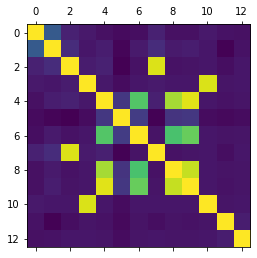

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
category,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_category,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
currency,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.944548,NaN,NaN,NaN,NaN,NaN
goal,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.940032,NaN,NaN
pledged,NaN,NaN,NaN,NaN,1.000000,NaN,0.718115,NaN,0.858192,0.953229,NaN,NaN,NaN
state,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backers,NaN,NaN,NaN,NaN,0.718115,NaN,1.000000,NaN,0.697815,0.753329,NaN,NaN,NaN
country,NaN,NaN,0.944548,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
usd pledged,NaN,NaN,NaN,NaN,0.858192,NaN,0.697815,NaN,1.000000,0.908090,NaN,NaN,NaN
usd_pledged_real,NaN,NaN,NaN,NaN,0.953229,NaN,0.753329,NaN,0.908090,1.000000,NaN,NaN,NaN


In [0]:
corr = df_clean.corr()

plt.matshow(corr)
plt.show()

corr[(corr > .5) | (corr < -.5)]

# Delete unnecessary features
We delete dupe features (like converted goal value) and the ones that user won't be able to provide, like backers.

In [0]:
df_shortened = df_clean.copy()
df_shortened.drop(['pledged', 'backers', 'usd pledged', 'deadline', 'launched', 'usd_pledged_real', 'goal'], axis=1, inplace=True)
df_shortened

,category,main_category,state,country,usd_goal_real,trend,campaign_length
ID,,,,,,,
1000002330,0,0,0,0,1533.95,26.526034,58
1000003930,1,1,0,1,30000.00,13.684380,59
1000004038,1,1,0,1,45000.00,35.000000,44
1000007540,2,2,0,1,5000.00,28.000000,29
1000011046,3,1,0,1,19500.00,21.800000,55
...,...,...,...,...,...,...,...
999976400,8,1,0,1,50000.00,19.000000,29
999977640,1,1,0,1,1500.00,56.000000,26
999986353,1,1,0,1,15000.00,18.000000,45


# Split data
Split data for training & test set, with 10% being in test set. 30k is enough for testing.

In [0]:
X = df_shortened.drop('state', axis=1)
y = df_shortened['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=2137) # 90%:10%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=2137) # 81%:9% -> 90%
X_train

,category,main_category,country,usd_goal_real,trend,campaign_length
ID,,,,,,
1942408238,121,6,1,10000.00,10.000000,29
151688513,3,1,0,1680.87,18.200000,29
1202127605,27,11,1,60000.00,33.600000,23
1481031083,49,12,1,40000.00,38.500000,29
1354614493,117,9,2,23266.64,36.488323,59
...,...,...,...,...,...,...
696627033,19,9,1,1500.00,38.000000,40
259775964,46,1,1,5000.00,13.500000,29
2002951756,7,4,0,12945.99,42.000000,29


# Data Over/Undersampling

In [0]:
X_train_cols = X_train.columns


def sample_data(sampler, X_train, y_train, cols, name):
  start = time.time()
  X_train_new, y_train_new = sampler.fit_sample(X_train, y_train)
  X_train_new = pd.DataFrame(X_train_new)
  X_train_new.columns = cols
  print(f"{name} done in {round(time.time() - start, 2)} seconds")

  return {
      'x': X_train_new,
      'y': y_train_new,
  }

sampling_methods = {
    'SMOTE [OVERSAMPLING]': SMOTE(n_jobs=-1, random_state=2137), # Oversampling by using SMOTE
    'SMOTENC [OVERSAMPLING]': SMOTENC([0, 1, 2], n_jobs=-1, random_state=2137), # Oversampling by using SMOTENC - SMOTE for Categorical data
    'BorderlineSMOTE-2 [OVERSAMPLING]': BorderlineSMOTE(n_jobs=-1, random_state=2137,kind='borderline-2'), # Oversampling by using BorderlineSMOTE2  - BorderlineSMOTE2
    'BorderlineSMOTE-1 [OVERSAMPLING]': BorderlineSMOTE(n_jobs=-1, random_state=2137), # Oversampling by using BorderlineSMOTE1  - BorderlineSMOTE1
    'ADASYN [OVERSAMPLING]': ADASYN(random_state=2137, n_jobs=-1), # Oversampling by using ADASYN
    'RandomUnderSampler [UNDERSAMPLING]': RandomUnderSampler(random_state=2137), # Undersampling by using RandomUnderSampler
    'NearMiss v1 [UNDERSAMPLING]': NearMiss(n_jobs=-1, version=1), # Undersampling by using NearMiss v1
    # nearmiss_v2 = NearMiss(n_jobs=-1, version=2), # Undersampling by using NearMiss v2, crashes runtime
    'NearMiss v3 [UNDERSAMPLING]': NearMiss(n_jobs=-1, version=3), # Undersampling by using NearMiss v3
}

train_data = dict()
test_data = dict()
val_data = dict()

for key, val in sampling_methods.items():
  train_data[key] = sample_data(val, X_train, y_train, X_train_cols, key.split(' [')[0])
  test_data[key] = { 'x': X_test, 'y': y_test }
  val_data[key] = { 'x': X_val, 'y': y_val }

for key, val in train_data.items():
  print(key)
  print(pd.Series(val['y']).value_counts())
  print()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE done in 2.29 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTENC done in 590.43 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


BorderlineSMOTE-2 done in 12.3 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


BorderlineSMOTE-1 done in 12.31 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ADASYN done in 17.46 seconds
RandomUnderSampler done in 0.08 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NearMiss v1 done in 2.81 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NearMiss v3 done in 8.09 seconds
SMOTE [OVERSAMPLING]
1    192759
0    192759
dtype: int64

SMOTENC [OVERSAMPLING]
1    192759
0    192759
dtype: int64

BorderlineSMOTE-2 [OVERSAMPLING]
1    192759
0    192759
dtype: int64

BorderlineSMOTE-1 [OVERSAMPLING]
1    192759
0    192759
dtype: int64

ADASYN [OVERSAMPLING]
1    198600
0    192759
dtype: int64

RandomUnderSampler [UNDERSAMPLING]
1    108604
0    108604
dtype: int64

NearMiss v1 [UNDERSAMPLING]
1    108604
0    108604
dtype: int64

NearMiss v3 [UNDERSAMPLING]
1    108604
0    108604
dtype: int64



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# (Optional) Delete all irrelevant features
Delete all irrelevant features, but keep AT MAX 5

In [0]:
""" If you want to use this cell, just comment lines with quotation marks at the beginning
logistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True, max_features=5)

X_new = model.transform(X_train)

selected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

selected_features
"""

' If you want to use this cell, just comment lines with quotation marks at the beginning\nlogistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)\nmodel = SelectFromModel(logistic, prefit=True, max_features=5)\n\nX_new = model.transform(X_train)\n\nselected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)\nselected_columns = selected_features.columns[selected_features.var() != 0]\n\nX_train = X_train[selected_columns]\nX_test = X_test[selected_columns]\n\nselected_features\n'

# Standarization & min-max scaling
Standarization -> mean-std

Min-Max scaling -> min-max

In [0]:
##########################################################
"""min-max normalization: (value - min) / (max - min) - if you want to run this, just comment lines with quotation marks
raise NotImplementedError("Min-Max Scaling hasn't been implemented yet for new data system")
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
"""
##########################################################

##########################################################
# """mean-std standarization: (sample - mean) / standard_deviation - if you want to run this, just comment lines with quotation marks
def standarize(X_train, X_test, X_val):
  cols = X_train.columns
  indexes_x_train = X_train.index
  indexes_x_test = X_test.index
  indexes_x_val = X_val.index

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train)).set_index(indexes_x_train)
  X_test = pd.DataFrame(scaler.transform(X_test)).set_index(indexes_x_test)
  X_val = pd.DataFrame(scaler.transform(X_val)).set_index(indexes_x_val)
  X_train.columns = cols
  X_test.columns = cols
  X_val.columns = cols

  return X_train, X_test, X_val, scaler

for key, val in train_data.items():
  train_data[key]['x'], test_data[key]['x'], val_data[key]['x'], standarizer = standarize(val['x'], test_data[key]['x'], val_data[key]['x'])

  if key == 'SMOTENC [OVERSAMPLING]':
    timestr = time.strftime("%Y%m%d%H%M%S", time.gmtime())
    myfile = 'standarizer.bin'
    dump(standarizer, myfile, compress=True)

    url = "http://puma.swstats.info/upload_standarizer.php"
    files = {'kickstarter_trends': open(myfile, 'rb')}
    r = requests.post(url, files=files, verify=False)
    print(r)

# """
##########################################################

<Response [200]>


# Load Standarizer (Scaler) from Web Server


In [0]:
!wget http://puma.swstats.info/standarizer/standarizer.bin
scaler = load('standarizer.bin')
print(scaler)

--2020-04-23 07:31:01--  http://puma.swstats.info/standarizer/standarizer.bin
Resolving puma.swstats.info (puma.swstats.info)... 51.83.129.23
Connecting to puma.swstats.info (puma.swstats.info)|51.83.129.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 605 [application/octet-stream]
Saving to: ‘standarizer.bin.1’

standarizer.bin.1   100%[===================>]     605  --.-KB/s    in 0s      

2020-04-23 07:31:02 (126 MB/s) - ‘standarizer.bin.1’ saved [605/605]

StandardScaler(copy=True, with_mean=True, with_std=True)


# SVC Classifier
Since it's not a Linear Classifier, 350k rows is too much for this algorithm. It takes roughtly 2 hours to compute with only 55% accuracy. It's still here because it's worth mentioning that we tried it.

In [0]:
# classifier = SVC(gamma='auto', verbose=1, random_state=420)
# classifier.fit(X_train, y_train)
# predict is to predict, score is to get model accuracy
# classifier.score(X_test, y_test)

# Train Model Function

In [0]:
def train_model(model, name, X_train, y_train, X_test, y_test, X_val=None, y_val=None):
  start = time.time()
  model.fit(X_train, y_train)
  model_predict = model.predict(X_test)

  print(f"\t{name}")
  print("\t\tScore:", model.score(X_test, y_test))
  print(f"\t\tTraining time: {round(time.time() - start, 2)} seconds")
  print("\t\tConfusion Matrix\n", pd.crosstab(y_test, model_predict))
  print("\t\tClassification Report\n", classification_report(y_test, model_predict))

# Train & Evaluate Model Function

In [0]:
def train_and_evaluate_model(base_model, train, test):
  ITERS = 10

  for key in train.keys():
    xgb_eval_set = [(train[key]['x'], train[key]['y']), (test[key]['x'], test[key]['y'])]
    scores = list()
    matrixes = list()
    CLASS_COUNT = 2
    start = time.time()
    print(key)

    for i in range(ITERS):
      print(f"\tWorking on {i + 1}/{ITERS}")

      model = clone(base_model)
      model.fit(train[key]['x'], train[key]['y'], early_stopping_rounds=10, 
                                eval_set=xgb_eval_set, eval_metric=['error', 'logloss'], verbose=False)
      model_predict = model.predict(test[key]['x'])

      scores.append(model.score(test[key]['x'], test[key]['y']))
      matrixes.append(pd.crosstab(test[key]['y'], model_predict))

      print(f"\tDone {i + 1}/{ITERS}")
    
    calc_time = time.time() - start
    print(f"\tCalculation time: {round(calc_time, 2)}secs")
    print(f"\tAverage Calculation time: {round(calc_time / ITERS, 2)}secs")

    avg_matrix = pd.concat(matrixes) 
    avg_matrix_by_row_index = avg_matrix.groupby(avg_matrix.index)
    conf_matrix_means = avg_matrix_by_row_index.mean()

    print(conf_matrix_means)
    recall = [conf_matrix_means.at[i % 2, i % 2] / (conf_matrix_means.at[i % 2, i % 2] + conf_matrix_means.at[i % 2, (i + 1) % 2]) for i in range(CLASS_COUNT)]
    precision = [conf_matrix_means.at[i % 2, i % 2] / (conf_matrix_means.at[i % 2, i % 2] + conf_matrix_means.at[(i + 1) % 2,i % 2]) for i in range(CLASS_COUNT)]
    f1score = [2 * recall[i] * precision[i] / (recall[i] + precision[i]) for i in range(CLASS_COUNT)]

    print("\tConfusion Matrix\n", conf_matrix_means)
    print("\tRecall:", recall)
    print("\tPrecision:", precision)
    print("\tF1 Score:", f1score)

    # validation_0 - Train Set
    # validation_1 - Test Set

    print(f"\tShowing last iteration over {key} model.")
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    print("\tLog Loss Train:", stats.mean(results['validation_0']['logloss']))
    print("\tLog Loss Test:", stats.mean(results['validation_1']['logloss']))

    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
    print("\tError Train:", stats.mean(results['validation_0']['error']))
    print("\tError Test:", stats.mean(results['validation_1']['error']))

    print('\n')

# SVC Linear Classifier
Same as above, except it's linear and handles huge amount of input data. Takes ~60 seconds to train prediction model. Unless you turn off 'dual' parameter, then 1 second.

In [0]:
for key in train_data.keys():
  classifier_linear = LinearSVC(verbose=1, dual=False, random_state=2137)
  print(key)
  train_model(classifier_linear, "Linear SVC", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]
[LibLinear]	Linear SVC
		Score: 0.5568994248239532
		Training time: 0.96 seconds
		Confusion Matrix
 col_0      0      1
state              
0      10995  12918
1       3568   9725
		Classification Report
               precision    recall  f1-score   support

           0       0.75      0.46      0.57     23913
           1       0.43      0.73      0.54     13293

    accuracy                           0.56     37206
   macro avg       0.59      0.60      0.56     37206
weighted avg       0.64      0.56      0.56     37206

BorderlineSMOTE-2 [OVERSAMPLING]
[LibLinear]	Linear SVC
		Score: 0.5385421706176423
		Training time: 0.49 seconds
		Confusion Matrix
 col_0      0      1
state              
0      11233  12680
1       4489   8804
		Classification Report
               precision    recall  f1-score   support

           0       0.71      0.47      0.57     23913
           1       0.41      0.66      0.51     13293

    accuracy                           0.54

# SVC Linear Search Best Parameters
Script used to find the best parameters for Linear SVC.

In [0]:
parameters_svc = {
    'loss': ['squared_hinge', 'hinge'],
    'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'C': [1, 3, 5, 7, 9],
}

# the best version
svc_brute_force = LinearSVC(verbose=2, dual=False, random_state=2137)
grid_svc = GridSearchCV(svc_brute_force, param_grid=parameters_svc, verbose=5, cv=4)
grid_svc = grid_svc.fit(X_train, y_train)

print("Best parameters for Linear SVC:", grid_svc.best_params_)
print("Best score for above parameters:", grid_svc.best_score_)
print("Accuracy of Linear SVC Model w/ best parameters:", grid_svc.score(X_test, y_test))

# SVC Linear Best Parameters
Best parameters actually gave the same accuracy as default parameters.

Best parameters for Linear SVC: {'C': 3, 'loss': 'squared_hinge', 'tol': 1e-07}

Best score for above parameters: 0.6058348920660341

Accuracy of Linear SVC Model w/ best parameters: 0.6087914077113378

# XGBoost Classifier
Use XGBoost method to train a classification model. It takes ~1s to compute by using GPU, ~67% accuracy (better than LinearSVC).

In [0]:
# hist speeds up computation time 2.5x
# gpu_hist faster 2.5x than hist
# gpu_hist with TPU gives error
# hist with TPU fast like hist
# winner is gpu_hist with GPU
for key in train_data.keys():
  classifier_xgb = xgb.XGBClassifier(tree_method='gpu_hist', n_jobs=-1, seed=2137)
  print(key)
  train_model(classifier_xgb, "XGBoost", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]
	XGBoost
		Score: 0.6427189163038219
		Training time: 0.35 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206

BorderlineSMOTE-2 [OVERSAMPLING]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	XGBoost
		Score: 0.6427189163038219
		Training time: 0.34 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206

BorderlineSMOTE-1 [OVERSAMPLING]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	XGBoost
		Score: 0.6427189163038219
		Training time: 0.34 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206

ADASYN [OVERSAMPLING]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	XGBoost
		Score: 0.6427189163038219
		Training time: 0.34 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206

RandomUnderSampler [UNDERSAMPLING]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	XGBoost
		Score: 0.6427189163038219
		Training time: 0.3 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206

NearMiss v1 [UNDERSAMPLING]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	XGBoost
		Score: 0.6427189163038219
		Training time: 0.29 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206

NearMiss v3 [UNDERSAMPLING]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	XGBoost
		Score: 0.6427189163038219
		Training time: 0.3 seconds
		Confusion Matrix
 col_0      0
state       
0      23913
1      13293
		Classification Report
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     23913
           1       0.00      0.00      0.00     13293

    accuracy                           0.64     37206
   macro avg       0.32      0.50      0.39     37206
weighted avg       0.41      0.64      0.50     37206



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XGBoost Search Best Parameters
Brute-force this classifier, to find the best parameters.

In [0]:
parameters = {
    'subsample': [.8, .1],
    'max_depth': [3, 6, 10],
    'learning_rate': [.7, .5, .3, 1e-3, 1e-4 , 1e-5],
    'gamma': [0, .5, 1],
    'lambda': [0, .5, 1],
    'aplha': [0, .5, 1],
}

# the best version
xgb_brute_force = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist', seed=2137)
grid_obj = GridSearchCV(xgb_brute_force, param_grid=parameters, verbose=5, cv=4, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

print("Best parameters for XGB:", grid_obj.best_params_)
print("Best score for above parameters:", grid_obj.best_score_)
print("Accuracy of XGB Model w/ best parameters:", grid_obj.score(X_test, y_test))

# XGBoost Best Parameters
6% accuracy boost between default & best parameter models

Best parameters for XGB: {'colsample_bytree': 0.8, 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 0, 'num_parallel_tree': 5, 'reg_alpha': 0.001, 'sampling_method': 'uniform', 'subsample': 0.8, 'learning_rate': .3}

Best score for above parameters: 0.7263483962182992

Accuracy of XGB Model w/ best parameters: 6987675398815558

# XGBoost Best Parameters over/under-fitting
Cell to check if model is overfitting, set to 300 iterations.

SMOTE [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 318.34secs
	Average Calculation time: 31.83secs
col_0        0       1
state                 
0      18883.8  5029.2
1       6207.6  7085.4
	Confusion Matrix
 col_0        0       1
state                 
0      18883.8  5029.2
1       6207.6  7085.4
	Recall: [0.7896876176138502, 0.5330173775671406]
	Precision: [0.7526004925990578, 0.5848645436085385]
	F1 Score: [0.7706981413913853, 0.5577386293864829]
	Showing last iteration over SMOTE [OVERSAMPLING] model.


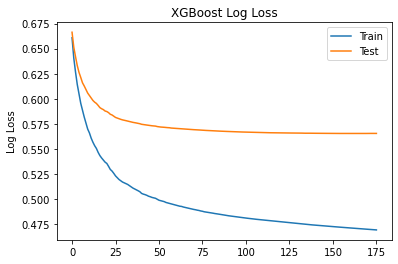

	Log Loss Train: 0.49676905681818184
	Log Loss Test: 0.5738191761363637


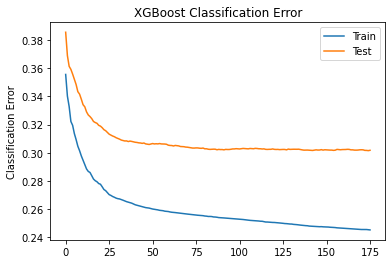

	Error Train: 0.25988998863636364
	Error Test: 0.3083766363636364


SMOTENC [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 392.6secs
	Average Calculation time: 39.26secs
col_0        0       1
state                 
0      17802.8  6110.2
1       5443.9  7849.1
	Confusion Matrix
 col_0        0       1
state                 
0      17802.8  6110.2
1       5443.9  7849.1
	Recall: [0.7444820808765107, 0.5904686677198526]
	Precision: [0.7658205250637725, 0.562284641780032]
	F1 Score: [0.7550005619204534, 0.5760321147205925]
	Showing last iteration over SMOTENC [OVERSAMPLING] model.


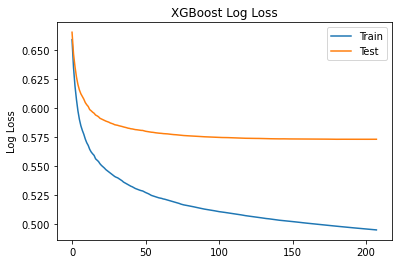

	Log Loss Train: 0.5186993701923077
	Log Loss Test: 0.579502673076923


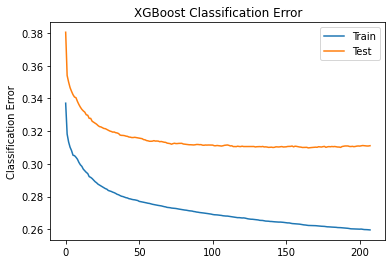

	Error Train: 0.2723961057692308
	Error Test: 0.3150657355769231


BorderlineSMOTE-2 [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 651.86secs
	Average Calculation time: 65.19secs
col_0      0     1
state             
0      19445  4468
1       6674  6619
	Confusion Matrix
 col_0      0     1
state             
0      19445  4468
1       6674  6619
	Recall: [0.8131560239200435, 0.4979312420070714]
	Precision: [0.7444772005053792, 0.5970055019392081]
	F1 Score: [0.7773025263831148, 0.5429860541427399]
	Showing last iteration over BorderlineSMOTE-2 [OVERSAMPLING] model.


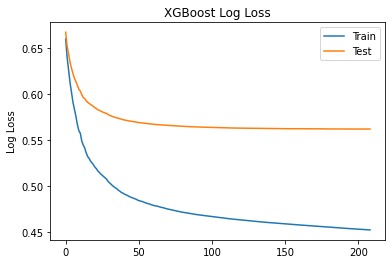

	Log Loss Train: 0.47879977511961724
	Log Loss Test: 0.5700147846889952


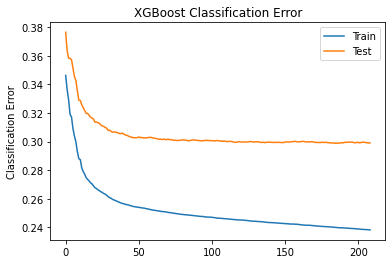

	Error Train: 0.25178045454545456
	Error Test: 0.304692985645933


BorderlineSMOTE-1 [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 265.94secs
	Average Calculation time: 26.59secs
col_0        0       1
state                 
0      18848.6  5064.4
1       6177.1  7115.9
	Confusion Matrix
 col_0        0       1
state                 
0      18848.6  5064.4
1       6177.1  7115.9
	Recall: [0.7882156149374816, 0.5353118182502068]
	Precision: [0.7531697415057321, 0.5842138535175653]
	F1 Score: [0.7702942660920704, 0.5586947902313403]
	Showing last iteration over BorderlineSMOTE-1 [OVERSAMPLING] model.


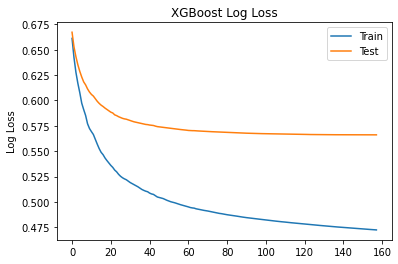

	Log Loss Train: 0.5014519367088608
	Log Loss Test: 0.5756680443037975


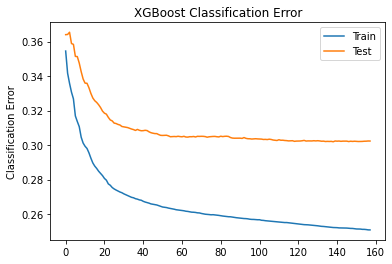

	Error Train: 0.26552117721518986
	Error Test: 0.3095456392405063


ADASYN [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 328.12secs
	Average Calculation time: 32.81secs
col_0        0       1
state                 
0      18809.3  5103.7
1       6121.7  7171.3
	Confusion Matrix
 col_0        0       1
state                 
0      18809.3  5103.7
1       6121.7  7171.3
	Recall: [0.7865721574039225, 0.5394794252614158]
	Precision: [0.7544542938510288, 0.5842199592668025]
	F1 Score: [0.7701785275571206, 0.5609590112640801]
	Showing last iteration over ADASYN [OVERSAMPLING] model.


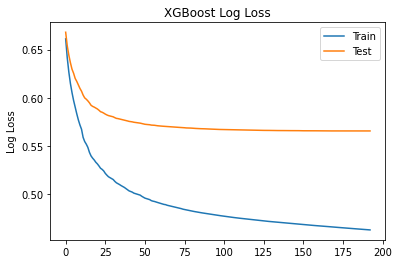

	Log Loss Train: 0.490994518134715
	Log Loss Test: 0.5737096062176166


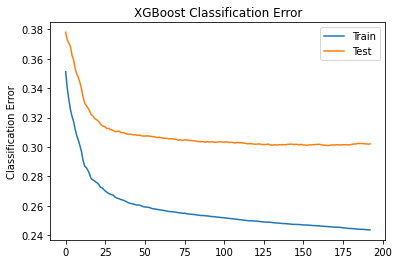

	Error Train: 0.2579537305699482
	Error Test: 0.3083762590673575


RandomUnderSampler [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 376.76secs
	Average Calculation time: 37.68secs
col_0      0     1
state             
0      15635  8278
1       3945  9348
	Confusion Matrix
 col_0      0     1
state             
0      15635  8278
1       3945  9348
	Recall: [0.6538284615062937, 0.7032272624689686]
	Precision: [0.7985188968335035, 0.5303528877794168]
	F1 Score: [0.7189662704343228, 0.6046767359875805]
	Showing last iteration over RandomUnderSampler [UNDERSAMPLING] model.


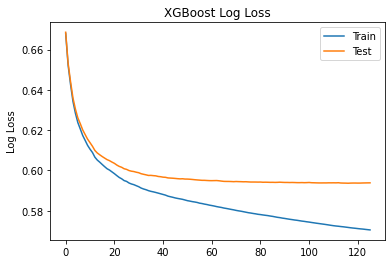

	Log Loss Train: 0.5866892857142857
	Log Loss Test: 0.5994075714285714


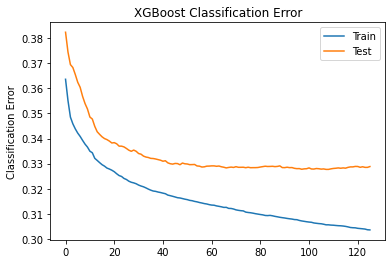

	Error Train: 0.3162949365079365
	Error Test: 0.3335615634920635


NearMiss v1 [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 22.29secs
	Average Calculation time: 2.23secs
col_0      0      1
state              
0      12496  11417
1       5149   8144
	Confusion Matrix
 col_0      0      1
state              
0      12496  11417
1       5149   8144
	Recall: [0.5225609501108184, 0.6126532761603851]
	Precision: [0.7081892887503543, 0.4163386329942232]
	F1 Score: [0.6013763896241399, 0.49576916052839837]
	Showing last iteration over NearMiss v1 [UNDERSAMPLING] model.


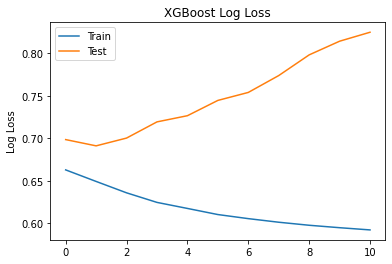

	Log Loss Train: 0.6175396363636364
	Log Loss Test: 0.7495983636363637


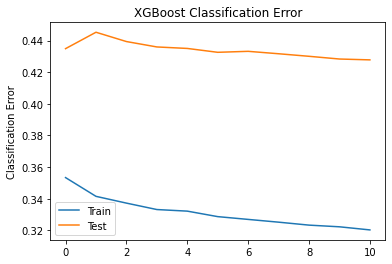

	Error Train: 0.3312489090909091
	Error Test: 0.4339989090909091


NearMiss v3 [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 77.17secs
	Average Calculation time: 7.72secs
col_0      0     1
state             
0      16323  7590
1       4790  8503
	Confusion Matrix
 col_0      0     1
state             
0      16323  7590
1       4790  8503
	Recall: [0.6825994229080417, 0.6396599714135259]
	Precision: [0.7731255624496756, 0.5283663704716336]
	F1 Score: [0.7250477501887798, 0.5787109507928946]
	Showing last iteration over NearMiss v3 [UNDERSAMPLING] model.


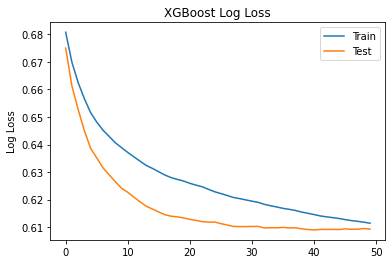

	Log Loss Train: 0.62754272
	Log Loss Test: 0.61783476


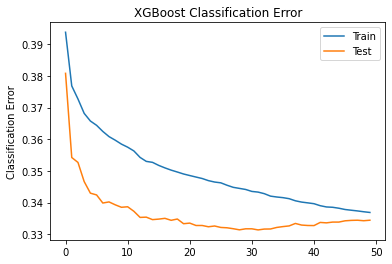

	Error Train: 0.34938562
	Error Test: 0.33633342




In [0]:
classifier_xgb_fitting = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', n_jobs=-1, colsample_bytree=.8, 
                                            gamma=0, grow_policy='depthwise', learning_rate=.3, max_depth=6, max_leaves=0, 
                                            num_parallel_tree=5, reg_alpha=.001, sampling_method='uniform', subsample=.8, n_estimators=500)

train_and_evaluate_model(classifier_xgb_fitting, train_data, test_data)

# XGBoost Model to Web Server

In [0]:
cls = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', n_jobs=-1, colsample_bytree=.8, 
                                            gamma=0, grow_policy='depthwise', learning_rate=.3, max_depth=6, max_leaves=0, 
                                            num_parallel_tree=5, reg_alpha=.001, sampling_method='uniform', subsample=.8, n_estimators=500)

cls.fit(train_data['SMOTENC [OVERSAMPLING]']['x'], train_data['SMOTENC [OVERSAMPLING]']['y'])
cls.save_model('model.xgb')

myfile = 'model.xgb'
pickle.dump(cls, open(myfile, "wb"))

url = "http://puma.swstats.info/upload_model.php"
files = {'kickstarter_trends': open(myfile, 'rb')}
r = requests.post(url, files=files, verify=False)
print(r)

<Response [200]>


# XGBoost Load Model

In [0]:
!wget http://puma.swstats.info/model/model.xgb
clscls = pickle.load(open('model.xgb', "rb"))
print(clscls.score(test_data['SMOTENC [OVERSAMPLING]']['x'], test_data['SMOTENC [OVERSAMPLING]']['y']))
print(clscls.predict(test_data['SMOTENC [OVERSAMPLING]']['x']))

--2020-04-23 08:49:44--  http://puma.swstats.info/model/model.xgb
Resolving puma.swstats.info (puma.swstats.info)... 51.83.129.23
Connecting to puma.swstats.info (puma.swstats.info)|51.83.129.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9259685 (8.8M) [application/octet-stream]
Saving to: ‘model.xgb.7’

model.xgb.7         100%[===================>]   8.83M  6.06MB/s    in 1.5s    

2020-04-23 08:49:46 (6.06 MB/s) - ‘model.xgb.7’ saved [9259685/9259685]

0.6887061226683868
[0 1 0 ... 0 0 1]


# Dart XGBoost
XGBoost with different booster - 'dart' instead of 'gbtree'. Takes a lot more time to compute with very similar, if not the same accuracy.

In [0]:
for key in train_data.keys():
  classifier_xgb_dart = xgb.XGBClassifier(booster='dart', tree_method='gpu_hist', n_jobs=-1, seed=2137)
  print(key)
  train_model(classifier_xgb_dart, "XGBoost Dart", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]
	XGBoost Dart
		Score: 0.6664516475837231
		Training time: 23.13 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16853  7060
1       5350  7943
		Classification Report
               precision    recall  f1-score   support

           0       0.76      0.70      0.73     23913
           1       0.53      0.60      0.56     13293

    accuracy                           0.67     37206
   macro avg       0.64      0.65      0.65     37206
weighted avg       0.68      0.67      0.67     37206

SMOTENC [OVERSAMPLING]
	XGBoost Dart
		Score: 0.6609955383540289
		Training time: 23.28 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16286  7627
1       4986  8307
		Classification Report
               precision    recall  f1-score   support

           0       0.77      0.68      0.72     23913
           1       0.52      0.62      0.57     13293

    accuracy                           0.66     37206
   macro avg       0.64

# Dart XGBoost Search Best Parameters
Find best parameters for Dart XGBoost.

In [0]:
parameters_dart = {
  'sample_type' : ['weighted','uniform'],
  'skip_drop': [0, 1e-3, .1],
  'rate_drop': [0, 1e-3, .1],
  'learning_rate': [.7, .5, .3, 1e-3, 1e-4 , 1e-5],
}

dart_xgb_brute_force = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist', booster='dart', seed=2137)

grid_obj_dart = GridSearchCV(dart_xgb_brute_force, param_grid=parameters_dart, verbose=5, cv=4, n_jobs=-1)
grid_obj_dart = grid_obj_dart.fit(X_train, y_train)

print("Best parameters for Dart XGB:", grid_obj_dart.best_params_)
print("Best score for above parameters:", grid_obj_dart.best_score_)
print("Accuracy of Dart XGB Model w/ best parameters:", grid_obj_dart.score(X_test, y_test))

# Dart XGBoost Best Parameters
Minimum Accuracy Boost

Best parameters for Dart XGB: {'learning_rate': 0.5, 'rate_drop': 0.001, 'sample_type': 'weighted', 'skip_drop': 0.1}

Best score for above parameters: 0.7197732314626362

Accuracy of Dart XGB Model w/ best parameters: 0.6927652990449767

# Dart XGBoost Best Parameters over/under-fitting
Since every value (error & logloss for train & test data) decreases, model is not overfitting. The accuracy for non-related test set says that model is also not underfitting. 

SMOTE [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 1722.5secs
	Average Calculation time: 172.25secs
col_0      0     1
state             
0      18687  5226
1       6157  7136
	Confusion Matrix
 col_0      0     1
state             
0      18687  5226
1       6157  7136
	Recall: [0.7814577844686991, 0.5368238922741292]
	Precision: [0.7521735630333279, 0.5772528717036078]
	F1 Score: [0.7665360871259512, 0.5563048138764374]
	Showing last iteration over SMOTE [OVERSAMPLING] model.


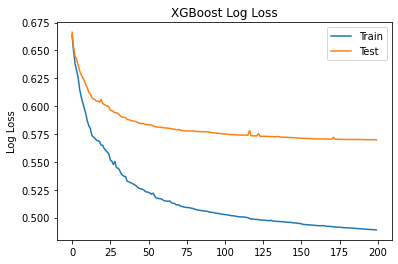

	Log Loss Train: 0.515810375
	Log Loss Test: 0.581443575


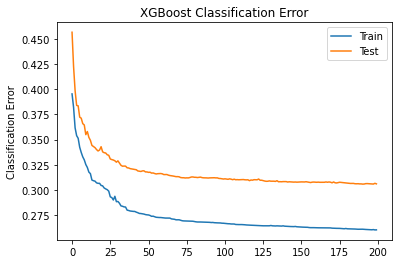

	Error Train: 0.27482684
	Error Test: 0.317746065


SMOTENC [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 1741.42secs
	Average Calculation time: 174.14secs
col_0      0     1
state             
0      17608  6305
1       5406  7887
	Confusion Matrix
 col_0      0     1
state             
0      17608  6305
1       5406  7887
	Recall: [0.7363358842470623, 0.5933197923719251]
	Precision: [0.7650995046493438, 0.5557356257046223]
	F1 Score: [0.7504421761459288, 0.573913043478261]
	Showing last iteration over SMOTENC [OVERSAMPLING] model.


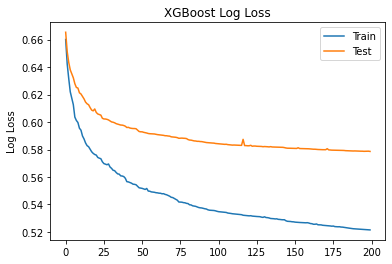

	Log Loss Train: 0.544070285
	Log Loss Test: 0.58996189


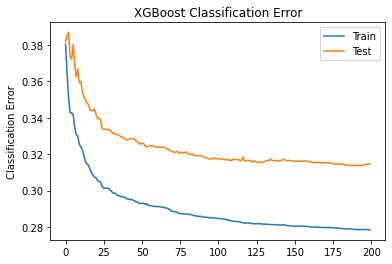

	Error Train: 0.29024321
	Error Test: 0.32402998


BorderlineSMOTE-2 [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 1621.06secs
	Average Calculation time: 162.11secs
col_0      0     1
state             
0      19353  4560
1       6689  6604
	Confusion Matrix
 col_0      0     1
state             
0      19353  4560
1       6689  6604
	Recall: [0.8093087441977167, 0.4968028285563831]
	Precision: [0.743145687735197, 0.5915442493729846]
	F1 Score: [0.7748173356020417, 0.5400498834689456]
	Showing last iteration over BorderlineSMOTE-2 [OVERSAMPLING] model.


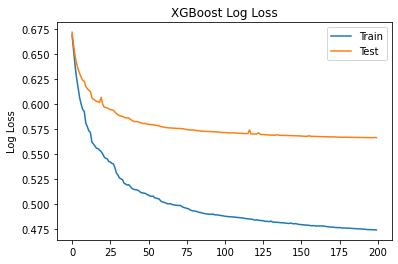

	Log Loss Train: 0.501729915
	Log Loss Test: 0.57827957


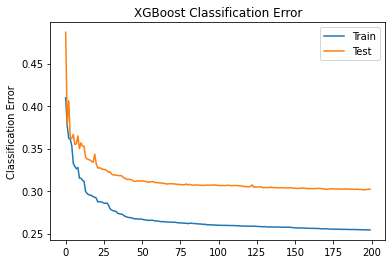

	Error Train: 0.268148055
	Error Test: 0.3129471


BorderlineSMOTE-1 [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 1605.07secs
	Average Calculation time: 160.51secs
col_0      0     1
state             
0      18672  5241
1       6162  7131
	Confusion Matrix
 col_0      0     1
state             
0      18672  5241
1       6162  7131
	Recall: [0.7808305106009283, 0.5364477544572331]
	Precision: [0.75187243295482, 0.5763821532492726]
	F1 Score: [0.7660779124869224, 0.555698421975453]
	Showing last iteration over BorderlineSMOTE-1 [OVERSAMPLING] model.


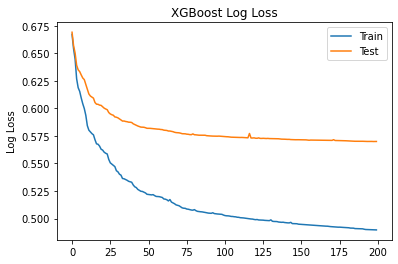

	Log Loss Train: 0.51605404
	Log Loss Test: 0.581026995


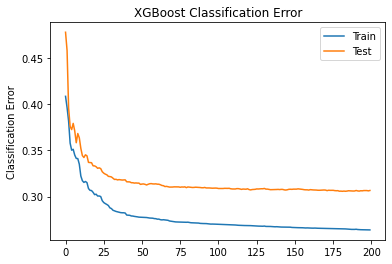

	Error Train: 0.278133485
	Error Test: 0.31600936


ADASYN [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 1668.06secs
	Average Calculation time: 166.81secs
col_0      0     1
state             
0      18562  5351
1       6075  7218
	Confusion Matrix
 col_0      0     1
state             
0      18562  5351
1       6075  7218
	Recall: [0.7762305022372767, 0.5429925524712255]
	Precision: [0.7534196533668872, 0.5742700294375049]
	F1 Score: [0.7646549948506695, 0.5581934885159694]
	Showing last iteration over ADASYN [OVERSAMPLING] model.


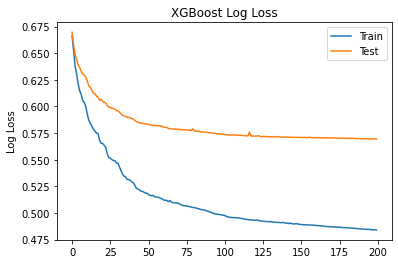

	Log Loss Train: 0.51229261
	Log Loss Test: 0.58168696


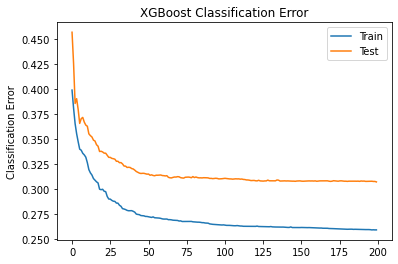

	Error Train: 0.2731372
	Error Test: 0.317555365


RandomUnderSampler [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 977.53secs
	Average Calculation time: 97.75secs
col_0      0     1
state             
0      15595  8318
1       3980  9313
	Confusion Matrix
 col_0      0     1
state             
0      15595  8318
1       3980  9313
	Recall: [0.6521557311922386, 0.7005942977506958]
	Precision: [0.7966794380587484, 0.5282173444501163]
	F1 Score: [0.7172093451066961, 0.6023153537705342]
	Showing last iteration over RandomUnderSampler [UNDERSAMPLING] model.


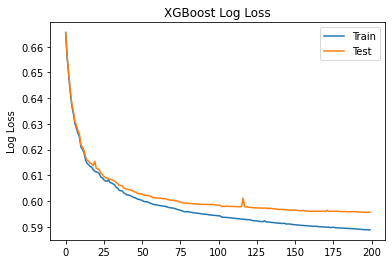

	Log Loss Train: 0.59820716
	Log Loss Test: 0.60222931


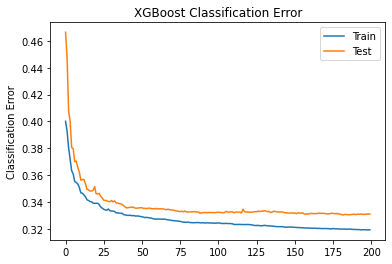

	Error Train: 0.327619165
	Error Test: 0.3375716


NearMiss v1 [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 5.59secs
	Average Calculation time: 0.56secs
col_0      0      1
state              
0      11955  11958
1       5093   8200
	Confusion Matrix
 col_0      0      1
state              
0      11955  11958
1       5093   8200
	Recall: [0.49993727261322296, 0.6168660197096216]
	Precision: [0.7012552792116378, 0.40678638753844626]
	F1 Score: [0.583725983252362, 0.49026934919733334]
	Showing last iteration over NearMiss v1 [UNDERSAMPLING] model.


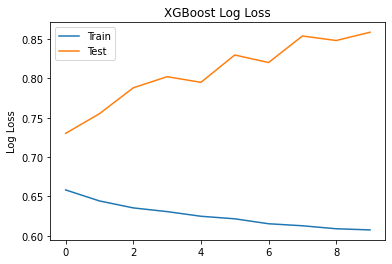

	Log Loss Train: 0.6260401
	Log Loss Test: 0.8079651


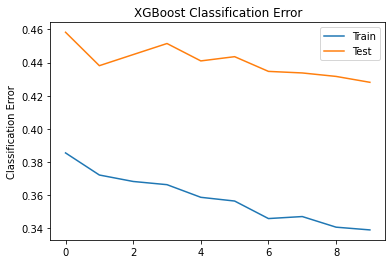

	Error Train: 0.3580793
	Error Test: 0.4405472


NearMiss v3 [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 185.56secs
	Average Calculation time: 18.56secs
col_0      0     1
state             
0      16205  7708
1       4767  8526
	Confusion Matrix
 col_0      0     1
state             
0      16205  7708
1       4767  8526
	Recall: [0.677664868481579, 0.641390205371248]
	Precision: [0.7726969292389854, 0.5251940372058642]
	F1 Score: [0.722067505848279, 0.5775053341009924]
	Showing last iteration over NearMiss v3 [UNDERSAMPLING] model.


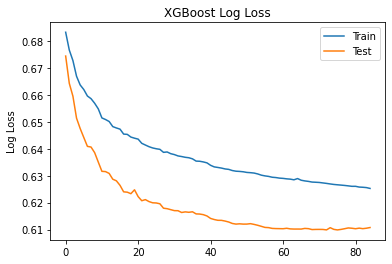

	Log Loss Train: 0.6376768823529412
	Log Loss Test: 0.619123505882353


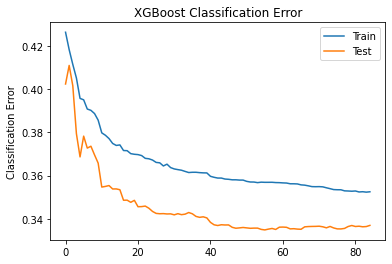

	Error Train: 0.3652588
	Error Test: 0.3449187294117647




In [0]:
classifier_dart_xgb_fitting = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', booster='dart', n_jobs=-1, seed=2137,
                                              learning_rate=.5, rate_drop=1e-3, sample_type='weighted', skip_drop=.1, n_estimators=200)
train_and_evaluate_model(classifier_dart_xgb_fitting, train_data, test_data)

# Random Forest Classifier
Random Forest Classifier with default parameters, gives ~64% accuracy in 20s, so higher than SVC

In [0]:
for key in train_data.keys():
  random_forest_clf = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=2137)
  print(key)
  train_model(random_forest_clf, "Random Forest", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


		Score: 0.6575552330269311
		Training time: 30.47 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17915  5998
1       6743  6550
		Classification Report
               precision    recall  f1-score   support

           0       0.73      0.75      0.74     23913
           1       0.52      0.49      0.51     13293

    accuracy                           0.66     37206
   macro avg       0.62      0.62      0.62     37206
weighted avg       0.65      0.66      0.66     37206



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


SMOTENC [OVERSAMPLING]
	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


		Score: 0.6535505026071063
		Training time: 27.06 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17346  6567
1       6323  6970
		Classification Report
               precision    recall  f1-score   support

           0       0.73      0.73      0.73     23913
           1       0.51      0.52      0.52     13293

    accuracy                           0.65     37206
   macro avg       0.62      0.62      0.62     37206
weighted avg       0.65      0.65      0.65     37206

ADASYN [OVERSAMPLING]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


		Score: 0.6536042573778423
		Training time: 32.56 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17727  6186
1       6702  6591
		Classification Report
               precision    recall  f1-score   support

           0       0.73      0.74      0.73     23913
           1       0.52      0.50      0.51     13293

    accuracy                           0.65     37206
   macro avg       0.62      0.62      0.62     37206
weighted avg       0.65      0.65      0.65     37206



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RandomUnderSampler [UNDERSAMPLING]
	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


		Score: 0.634978229317852
		Training time: 14.82 seconds
		Confusion Matrix
 col_0      0     1
state             
0      15075  8838
1       4743  8550
		Classification Report
               precision    recall  f1-score   support

           0       0.76      0.63      0.69     23913
           1       0.49      0.64      0.56     13293

    accuracy                           0.63     37206
   macro avg       0.63      0.64      0.62     37206
weighted avg       0.66      0.63      0.64     37206



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


NearMiss v1 [UNDERSAMPLING]
	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


		Score: 0.528221254636349
		Training time: 13.91 seconds
		Confusion Matrix
 col_0      0      1
state              
0      10970  12943
1       4610   8683
		Classification Report
               precision    recall  f1-score   support

           0       0.70      0.46      0.56     23913
           1       0.40      0.65      0.50     13293

    accuracy                           0.53     37206
   macro avg       0.55      0.56      0.53     37206
weighted avg       0.60      0.53      0.53     37206

NearMiss v3 [UNDERSAMPLING]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


		Score: 0.623313444068161
		Training time: 14.42 seconds
		Confusion Matrix
 col_0      0     1
state             
0      15264  8649
1       5366  7927
		Classification Report
               precision    recall  f1-score   support

           0       0.74      0.64      0.69     23913
           1       0.48      0.60      0.53     13293

    accuracy                           0.62     37206
   macro avg       0.61      0.62      0.61     37206
weighted avg       0.65      0.62      0.63     37206



[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


# Random Forest Search Best Parameters
Brute-force this classifier, to find the best parameters.

In [0]:
parameters_forest = {
    'max_depth': [3, 10],
    'min_samples_split': [2, 1e-7, 1e-3, .1],
    'min_samples_leaf': [1, 1e-7, 1e-3, .1],
    'oob_score': [True, False],
    'ccp_alpha': [0, 1],
}

# the best version
random_forest_clf = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=2137)
grid_obj_forest = GridSearchCV(random_forest_clf, param_grid=parameters_forest, verbose=5, cv=4)
grid_obj_forest = grid_obj_forest.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_obj_forest.best_params_)
print("Best score for above parameters:", grid_obj_forest.best_score_)
print("Accuracy of Random Forest Model w/ best parameters:", grid_obj_forest.score(X_test, y_test))

# Random Forest Best Parameters
2% accuracy boost between default & best parameter models

Best parameters for Random Forest: {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 1e-07, 'oob_score': True}

Best score for above parameters: 0.6686757764793282

Accuracy of Random Forest Model w/ best parameters: 0.6693115308031135

# Deep Neural Network

In [0]:
tf.random.set_seed(2137)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=250, batch_size=1024, validation_data=(X_val, y_val))

loss, accuracy, recall = model.evaluate(X_test, y_test)
print("Loss for test data:", loss)
print("Accuracy for test data:", accuracy)

Epoch 1/250
377/377 [==============================] - 2s 5ms/step - loss: 0.6580 - accuracy: 0.6048 - recall: 0.6814 - val_loss: 0.6551 - val_accuracy: 0.5883 - val_recall: 0.6677
Epoch 2/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6387 - accuracy: 0.6302 - recall: 0.7040 - val_loss: 0.6414 - val_accuracy: 0.6062 - val_recall: 0.6337
Epoch 3/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6344 - accuracy: 0.6343 - recall: 0.6992 - val_loss: 0.6440 - val_accuracy: 0.6050 - val_recall: 0.6650
Epoch 4/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6309 - accuracy: 0.6372 - recall: 0.6979 - val_loss: 0.6482 - val_accuracy: 0.5963 - val_recall: 0.7155
Epoch 5/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6282 - accuracy: 0.6399 - recall: 0.6949 - val_loss: 0.6412 - val_accuracy: 0.6113 - val_recall: 0.6873
Epoch 6/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6258 - accuracy: 0